<a href="https://colab.research.google.com/github/howru0321/AIGS538_Deep_Learning/blob/main/DL_project_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data as data_utils
import os

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
from datetime import datetime
from PIL import Image

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
base_dir = f'CA/{current_time}'

num_epochs=1000
num_save=100

In [ ]:
class Preprocess():
  def __init__(self, train_data, test_data):
    self.train_data = train_data
    self.test_data = test_data

    self.features = train_data.columns
    self.in_features = [col for col in train_data.columns if train_data[col].dtype == float and col not in ('median_house_value')]
    self.out_features = ['median_house_value']

    mean, std = self.get_features_mean_std(train_data)
    self.mean = mean
    self.std = std

  def get_features_mean_std(self, data):
    return data[self.features].mean(), data[self.features].std()

  def get_train_input_output(self):
    normalized = (self.train_data[self.features]-self.mean)/self.std
    input = torch.Tensor(normalized[self.in_features].values)
    output = torch.Tensor(normalized[self.out_features].values)
    return [input, output]

  def get_test_input_output(self):
    normalized = (self.test_data[self.features]-self.mean)/self.std
    input = torch.Tensor(normalized[self.in_features].values)
    output = torch.Tensor(normalized[self.out_features].values)
    return [input, output]

# get data
train_data = pd.read_csv('./sample_data/california_housing_train.csv')
test_data = pd.read_csv('./sample_data/california_housing_test.csv')

preprocessor = Preprocess(train_data=train_data, test_data=test_data)
train_dataset = preprocessor.get_train_input_output()
test_dataset = preprocessor.get_train_input_output()

train_dataset = data_utils.TensorDataset(train_dataset[0], train_dataset[1])
test_dataset = data_utils.TensorDataset(test_dataset[0], test_dataset[1])

# get dataloader
batch_size = 256
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [ ]:
class MLP(nn.Module):
  def __init__(self, regularizer_type: str, train_loader, test_loader, _lambda=1e-4):
    super().__init__()

    if regularizer_type == 'l1':
      self._lambda = _lambda
      self.norm = 1

    if regularizer_type == 'l2':
      self._lambda = _lambda
      self.norm = 2

    if regularizer_type == 'l3':
      self._lambda = _lambda
      self.norm = 3

    self.train_loader = train_loader
    self.test_loader = test_loader

    self.mlp = nn.Sequential(
      nn.Linear(8, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 1)
    )

    self.loss = nn.MSELoss()
    self.optimizer = optim.Adam(self.mlp.parameters(), lr=0.01)

  def forward(self, x):
    output = self.mlp(x)
    return output

  def get_weight(self):
    return self.mlp[0].weight

  def get_loss(self, output, label):
    first_layer_weight = self.get_weight()
    loss = self.loss(output, label) + self._lambda * torch.norm(first_layer_weight, self.norm)
    return loss

  def train(self, epochs, save):
    self.test_error_list=[]
    self.train_error_list=[]

    self.mlp.train()
    for epoch in tqdm(range(epochs)):
      train_error = 0
      for x, gt in self.train_loader:
        self.optimizer.zero_grad()
        outputs = self(x)

        # train error
        train_error += torch.abs(gt-outputs).sum()

        loss = self.get_loss(outputs, gt)
        loss.backward()
        self.optimizer.step()

      if (epoch+1)%save == 0 or epoch == 0:
        self.show_weight_map(epoch, base_dir)

      error = float(train_error/len(self.train_loader))
      self.train_error_list.append(error)
      if (epoch+1)%50 == 0 or epoch == 0:
        print(f'\nTrain Error : {error}')
      self.test(epoch)

    # # save error
    # with open(f'./L{self.norm}_test_error.txt', 'w') as f1:
    #   f1.write('\n'.join(self.test_error_list))
    # with open(f'./L{self.norm}_train_error.txt', 'w') as f2:
    #   f2.write('\n'.join(self.train_error_list))

  def test(self, epoch):
      error=0
      self.mlp.eval()
      with torch.no_grad():
        for x, gt in self.test_loader:
          outputs = self(x)
          error += torch.abs(gt-outputs).sum()

      error = float(error/len(self.test_loader))
      self.test_error_list.append(error)
      if (epoch+1)%50 == 0 or epoch == 0:
        print(f'Test Error : {error}')
      self.mlp.train()

  def show_weight_map(self, epoch, base_dir):
    base_dir = os.path.join(base_dir, f'L{self.norm}')
    os.makedirs(base_dir, exist_ok=True)
    w = self.get_weight()
    w = torch.mean(w, dim=0)

    # print(f'\n MAX : {w.max()}, MIN : {w.min()}')
    norm_w = torch.abs(w/torch.abs(w).max())
    image = np.repeat(norm_w.view(1,8,1).detach().numpy(),3,-1)

    # upscale image
    scale = 50
    new_image = np.zeros((image.shape[0]*scale, image.shape[1]*scale, image.shape[2]))

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        new_image[i*scale:(i+1)*scale, j*scale:(j+1)*scale] = image[i,j]

    plt.axis('off')
    save_path = os.path.join(base_dir, f'weight_{epoch}.png')
    plt.imsave(save_path, new_image, cmap='gray')
    plt.imshow(image, cmap='gray')

  0%|          | 0/1000 [00:00<?, ?it/s]


Train Error : 111.91352844238281


  0%|          | 1/1000 [00:02<40:38,  2.44s/it]

Test Error : 93.66295623779297


  5%|▌         | 50/1000 [00:37<10:54,  1.45it/s]


Train Error : 74.325927734375
Test Error : 74.670654296875


 10%|█         | 100/1000 [01:06<08:16,  1.81it/s]


Train Error : 68.89444732666016
Test Error : 68.06631469726562


 15%|█▌        | 150/1000 [01:35<07:21,  1.92it/s]


Train Error : 66.8887939453125
Test Error : 65.27264404296875


 20%|█▉        | 199/1000 [02:04<07:45,  1.72it/s]


Train Error : 65.87457275390625


 20%|██        | 200/1000 [02:05<08:56,  1.49it/s]

Test Error : 66.58323669433594


 25%|██▌       | 250/1000 [02:34<07:22,  1.70it/s]


Train Error : 65.55654907226562
Test Error : 64.12936401367188


 30%|███       | 300/1000 [03:03<06:03,  1.92it/s]


Train Error : 64.2164535522461
Test Error : 63.66930389404297


 35%|███▍      | 349/1000 [03:31<05:53,  1.84it/s]


Train Error : 62.34126663208008


 35%|███▌      | 350/1000 [03:31<05:50,  1.85it/s]

Test Error : 61.092498779296875


 40%|████      | 400/1000 [04:00<05:06,  1.96it/s]


Train Error : 62.75545883178711
Test Error : 60.13326644897461


 45%|████▌     | 450/1000 [04:29<06:29,  1.41it/s]


Train Error : 61.249568939208984
Test Error : 60.04404067993164


 50%|████▉     | 499/1000 [04:56<04:36,  1.81it/s]


Train Error : 61.75457763671875


 50%|█████     | 500/1000 [04:57<04:55,  1.69it/s]

Test Error : 60.770851135253906


 55%|█████▌    | 550/1000 [05:25<03:52,  1.93it/s]


Train Error : 61.62607955932617
Test Error : 63.09696960449219


 60%|██████    | 600/1000 [05:53<03:38,  1.83it/s]


Train Error : 62.08235168457031
Test Error : 61.89715576171875


 65%|██████▌   | 650/1000 [06:21<03:03,  1.91it/s]


Train Error : 62.4543342590332
Test Error : 62.80655288696289


 70%|███████   | 700/1000 [06:51<03:04,  1.62it/s]


Train Error : 60.468265533447266
Test Error : 60.09061813354492


 75%|███████▌  | 750/1000 [07:23<02:36,  1.60it/s]


Train Error : 60.26032257080078
Test Error : 60.00362777709961


 80%|████████  | 800/1000 [07:52<01:45,  1.89it/s]


Train Error : 60.97529983520508
Test Error : 61.71014404296875


 85%|████████▍ | 849/1000 [08:21<01:42,  1.47it/s]


Train Error : 61.44722366333008


 85%|████████▌ | 850/1000 [08:22<01:48,  1.38it/s]

Test Error : 63.70795822143555


 90%|████████▉ | 899/1000 [08:51<00:57,  1.77it/s]


Train Error : 59.56570053100586


 90%|█████████ | 900/1000 [08:51<00:56,  1.78it/s]

Test Error : 58.87456512451172


 95%|█████████▌| 950/1000 [09:20<00:27,  1.84it/s]


Train Error : 60.841636657714844
Test Error : 60.20439529418945


100%|█████████▉| 999/1000 [09:49<00:00,  1.90it/s]


Train Error : 60.519775390625


100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]

Test Error : 59.33164978027344


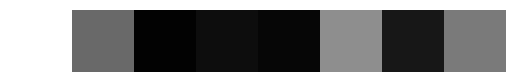

In [ ]:
# define model
model_l1 = MLP(regularizer_type='l1', train_loader=train_loader, test_loader=test_loader)
# train
model_l1.train(epochs=num_epochs, save=num_save)

l1_tr_err = model_l1.train_error_list
l1_te_err = model_l1.test_error_list

In [ ]:
# define model
model_l2 = MLP(regularizer_type='l2', train_loader=train_loader, test_loader=test_loader)
# train
model_l2.train(epochs=num_epochs, save=num_save)

l2_tr_err = model_l2.train_error_list
l2_te_err = model_l2.test_error_list

In [ ]:
# define model
model_l3 = MLP(regularizer_type='l3', train_loader=train_loader, test_loader=test_loader)
# train
model_l3.train(epochs=num_epochs, save=num_save)

l3_tr_err = model_l3.train_error_list
l3_te_err = model_l3.test_error_list

In [ ]:
# plot accuracy progress
plt.title("Train Error")
plt.plot(range(1,num_epochs+1),l1_tr_err,label="l1")
plt.plot(range(1,num_epochs+1),l2_tr_err,label="l2")
plt.plot(range(1,num_epochs+1),l3_tr_err,label="l3")
plt.ylabel("Error")
plt.xlabel("Training Epochs")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Test Error")
plt.plot(range(1,num_epochs+1),l1_te_err,label="l1")
plt.plot(range(1,num_epochs+1),l2_te_err,label="l2")
plt.plot(range(1,num_epochs+1),l3_te_err,label="l3")
plt.ylabel("Error")
plt.xlabel("Test Epochs")
plt.legend()
plt.show()

In [ ]:
def plot_images_from_subdirs(base_dir):
    for subdir, _, files in sorted(os.walk(base_dir)):
        image_files = sorted([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        if image_files:
            images = []
            for image_file in image_files:
                img_path = os.path.join(subdir, image_file)
                img = Image.open(img_path)
                images.append(img)

            num_images = len(images)
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
            plt.suptitle(os.path.basename(subdir), fontsize=16)
            if num_images == 1:
                axes = [axes]

            for ax, img, file_name in zip(axes, images, image_files):
                ax.imshow(img)
                ax.set_title(file_name)
                ax.axis('off')

            plt.show()

plot_images_from_subdirs(base_dir)